In [2]:
import os
import sys
import getopt

import parse_genet
import vi

import importlib

import simulate
import torch
import matplotlib.pyplot as plt
import numpy as np

import pyro.distributions as dist

import scipy.stats

import pandas as pd
import numpy as np
import string
import random
import time
import datetime

# Observation 

In [ ]:
## testing only using 1000 SNPs in summary stats in chr22
# observations: 
# collapsed >> uncollapsed (deleted uncollapsed code)
# phi_as_prior = False seems to give better results, but phi_as_prior = True gives more robust training (less noisy loss), probably because constraint on psi is more useful. 
# Does constrain_sigma help? I think constrain_psi does. 
# Seem to need desired_min_eig=1e-3 at least to avoid numerical issues. Could go lower if using float64 it seemed. 


In [3]:
##annotation path
bl_anno='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr'
deepsea='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/deepsea/deepsea_high_h2_chr'
enformer='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/enformer/enformer_high_h2_chr'
anno_file = bl_anno+','+deepsea+','+enformer



sim_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr',
    'save_fig_name':'1000SNP'      
}

chr22_dict =  {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22",
    'sst_file' : "test_data/wightman_chr22.tsv",
    'n_gwas' : 762971, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr',
    'save_fig_name':'chr22'      
}


# Main Function

In [40]:
importlib.reload(simulate)
importlib.reload(parse_genet)
## add annotations, add iteration. add path for saving the plot
## can still run if you want to simulate anno
def check_sim_result(param_dict,  chrom=22, refit_time=1,prop_nz = 0.2):
    
    ## handling the pic saving repo
    random_name = ''.join(random.choices(string.ascii_lowercase +string.digits, k=3))
    date = pd.Timestamp(datetime.date.today()).strftime("%m%d")
    save_dir = '/gpfs/commons/home/tlin/pic/casioPR/simulation/' + date
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    path= save_dir + '/' + param_dict['save_fig_name'] + '_' + 'iter%d'%refit_time +'_'+random_name +'_'
    print("fig will be saved in %s"%path)
    
    if '1kg' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
    elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

    ref_df = ref_df[ref_df.CHR == chrom]
    vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
    vld_df = vld_df[vld_df.CHR == chrom]
    sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
    ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                      
    print("There are %s ld_block. \n" %(len(ld_blk)))
    
    if len(sst_dict) == 991:  ## This will be sim
        beta_true, beta_mrg, annotations, anno_names = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], len(sst_dict), sst_dict,anno_path = param_dict['anno_path'], chrom=chrom,prop_nz = prop_nz)
        sst_dict["BETA"] = beta_mrg
    else:
        annotations, anno_names =  parse_genet.parse_anno(param_dict["anno_path"], sst_dict, chrom = chrom)
        beta_true = sst_dict['BETA']
 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    anno_names.insert(0,'intercept')
    print("start VI...")
    importlib.reload(vi)
    #one = torch.tensor(1., device=device)
    
    pearsonr_list=[]
    anno_list=pd.DataFrame()

    for i in range(refit_time):
        print('Fitting model %d time(s)'% (i+1))
        losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)
        plt.plot(losses);plt.title('losses');#plt.savefig(save_dir + '/loss/'+ param_dict['save_fig_name'] + '_' + 'iter%d'%refit_time +'_'+random_name +'_' +'loss_%s.png'%i);
        
        if i == refit_time-1:
            plt.savefig(path+'loss.pdf',format ='pdf',bbox_inches='tight');plt.show()
            
        
        r=scipy.stats.pearsonr(beta_true,beta)[0]
        pearsonr_list.append(r)

        ## check anno
        anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
        anno_list = anno_list.append(anno_df["mean"].to_frame().T, ignore_index=True)  
    
    ## plot anno  
    plt.bar(anno_list.mean().index, anno_list.mean(), yerr=anno_list.std(), capsize=3, color='turquoise')
    plt.xticks(anno_list.mean().index, anno_names, rotation=90)
    plt.ylabel('weight')
    plt.title('iterate %d times'%(refit_time))
    plt.savefig(path+'anno_weight.pdf',format ='pdf',bbox_inches='tight');plt.show()
    #print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)
    
    if len(sst_dict) == 991:
        plt.plot(anno_list.iloc[:][1],anno_list.iloc[:][2], marker='X', linestyle='--', color='y')
        plt.xlabel('perfect anno')
        plt.ylabel('random anno')
        plt.title('annotation weights')
        plt.savefig(path+'anno_weight.pdf',format ='pdf');plt.show()   
        

    ## plot r
    plt.plot(range(refit_time), pearsonr_list, marker='o', linestyle='--', color='c')
    ax = plt.axes()
    #ax.set_ylim(0.5, 1)
    plt.xticks(list(range(refit_time)),list(range(1,refit_time+1)))
    plt.title('pearson r for betas in every iteration')
    plt.savefig(path+'betas.pdf',format ='pdf');plt.show()   
    
    print('anno_weight')
    print(anno_list)
    
    print('\n')
    print('person R list')
    print(pearsonr_list)
    return(anno_list,pearsonr_list)        

# Try Real Annotations

## trying bl 

fig will be saved in /gpfs/commons/home/tlin/pic/casioPR/simulation/1004/just_testing_iter2_m04_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
There are 24 ld_block. 

... parse annotations ...
Reading annotations from 1 file(s)... 
Successfully loaded 5 annotations for 271699 SNPs
Total of 14014 SNPs left after merging with sst
Done in 0.48 seconds 

start VI...
Fitting model 1 time(s)
... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.351e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03),

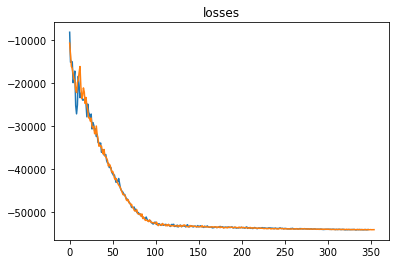

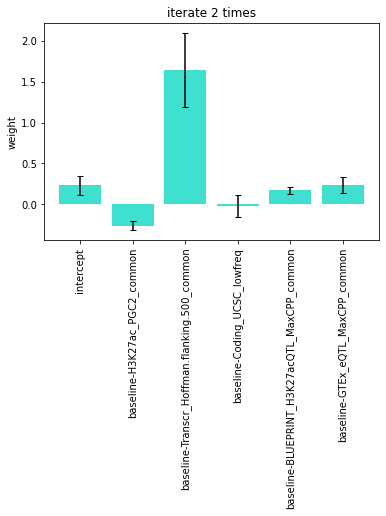

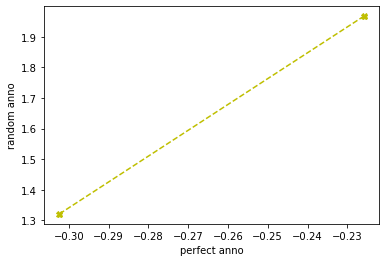

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


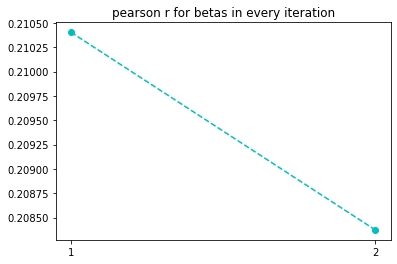

anno_weight
          0         1         2         3         4         5
0  0.153066 -0.302366  1.321156 -0.115858  0.142590  0.170191
1  0.314159 -0.225856  1.966719  0.074348  0.199766  0.307432


person R list
[0.21040513291597843, 0.2083731848913896]


In [42]:
##just testing
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22",
    'sst_file' : "test_data/wightman_chr22.tsv",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr',
    'save_fig_name':'just_testing'      
}


# param_dict = {
#     'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
#     'bim_prefix' : "test_data/test",
#     'sst_file' : "test_data/sumstats.txt",
#     'n_gwas' : 200000, 
#     'out_dir' : "test_data",
#     "seed" : 42, 
#     "beta_std" : "False", 
#     "n_iter" : 1000, 
#     'anno_path': False,
#     'save_fig_name':'test'      
# }
test = check_sim_result(param_dict,refit_time = 2)


save fig in /gpfs/commons/home/tlin/pic/casioPR/simulation/0922/bl_10_iter_1000SNP_22p_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
There are 4 ld_block. 

... parse annotations ...
Reading annotations from 1 file(s)... 
Successfully loaded 5 annotations for 271699 SNPs
Total of 991 SNPs left after merging with sst
Done in 0.61 seconds 

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 305 iterations. Increasing num_particles to 2.
Done after 101 iterations. Increasing num_particles to 4.
Done after 355 iterations. Increasing num_particles t

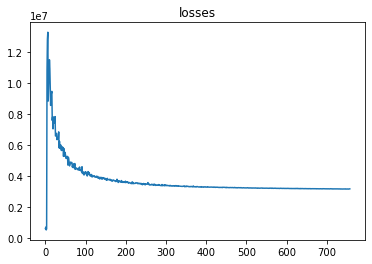

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 218 iterations. Increasing num_particles to 2.
Done after 89 iterations. Increasing num_particles to 4.
Done after 192 iterations. Increasing num_particles to 8.
Done in 35.22 seconds 



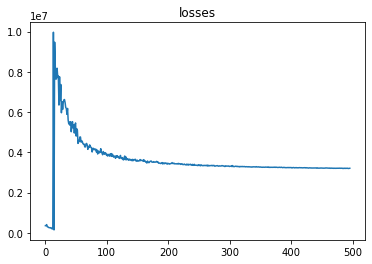

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 220 iterations. Increasing num_particles to 2.
Done after 89 iterations. Increasing num_particles to 4.
Done after 57 iterations. Increasing num_particles to 8.
Done in 20.31 seconds 



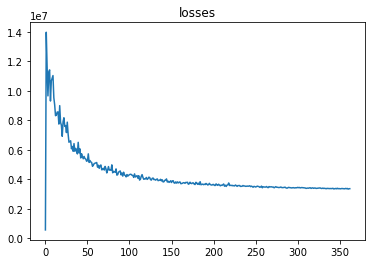

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 390 iterations. Increasing num_particles to 2.
Done after 65 iterations. Increasing num_particles to 4.
Done after 283 iterations. Increasing num_particles to 8.
Done in 49.83 seconds 



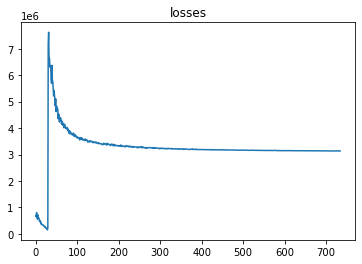

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 280 iterations. Increasing num_particles to 2.
Done after 116 iterations. Increasing num_particles to 4.
Done after 170 iterations. Increasing num_particles to 8.
Done in 36.88 seconds 



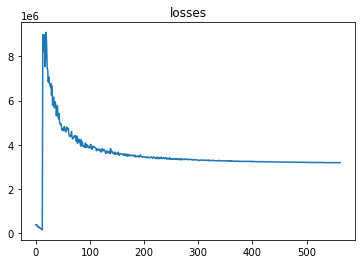

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 222 iterations. Increasing num_particles to 2.
Done after 34 iterations. Increasing num_particles to 4.
Done after 168 iterations. Increasing num_particles to 8.
Done in 29.62 seconds 



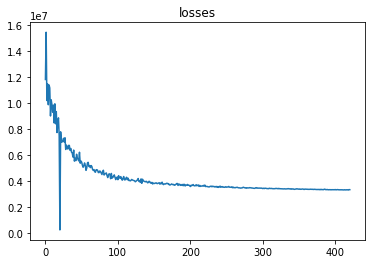

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 202 iterations. Increasing num_particles to 2.
Done after 66 iterations. Increasing num_particles to 4.
Done after 257 iterations. Increasing num_particles to 8.
Done in 40.47 seconds 



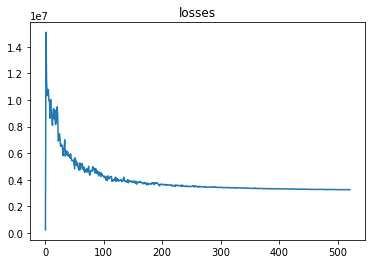

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 207 iterations. Increasing num_particles to 2.
Done after 117 iterations. Increasing num_particles to 4.
Done after 345 iterations. Increasing num_particles to 8.
Done in 54.10 seconds 



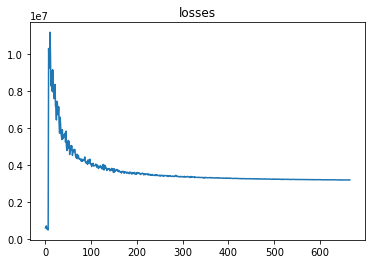

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 249 iterations. Increasing num_particles to 2.
Done after 94 iterations. Increasing num_particles to 4.
Done after 186 iterations. Increasing num_particles to 8.
Done in 36.08 seconds 



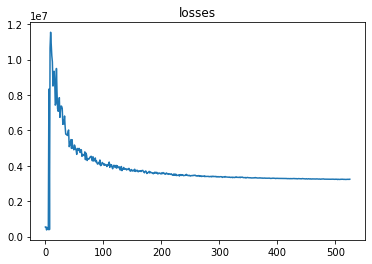

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 281 iterations. Increasing num_particles to 2.
Done after 132 iterations. Increasing num_particles to 4.
Done after 142 iterations. Increasing num_particles to 8.
Done in 33.80 seconds 



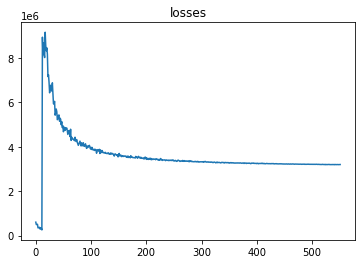

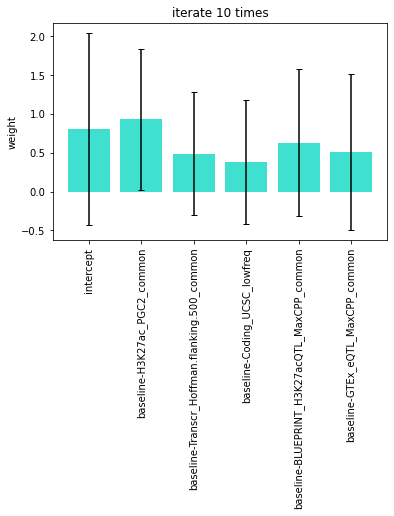

{'mean': tensor([ 1.5759, -0.3556,  0.6844, -0.6506,  1.0520,  1.6919]), 'std': tensor([0.1034, 0.1049, 0.1284, 0.4543, 0.0939, 0.1035]), '5%': tensor([ 1.4013, -0.5241,  0.4858, -1.3963,  0.8962,  1.5210]), '95%': tensor([ 1.7222, -0.1917,  0.8834,  0.2081,  1.1846,  1.8446])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


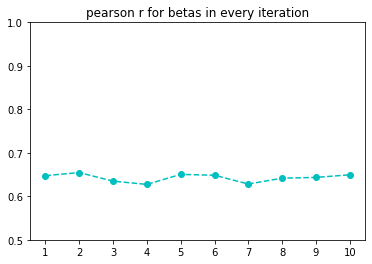

[0.6474970349895947, 0.6546197581470773, 0.6348279259196304, 0.6273886564921661, 0.6504097131467592, 0.6484574787875508, 0.6282181088714868, 0.6417021191370557, 0.6434935392065287, 0.6494408986797334]


In [5]:
## on 1k SNP
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr',
    'save_fig_path':'0922/bl_10_iter_1000SNP'      
}

test = check_sim_result(param_dict, "check_anno",refit_time = 10)

save fig in /gpfs/commons/home/tlin/pic/casioPR/simulation/0922/bl_5_iter_all_chr22_2g6_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
There are 24 ld_block. 

... parse annotations ...
Reading annotations from 1 file(s)... 
Successfully loaded 5 annotations for 271699 SNPs
Total of 14014 SNPs left after merging with sst
Done in 0.53 seconds 

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.351e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min 

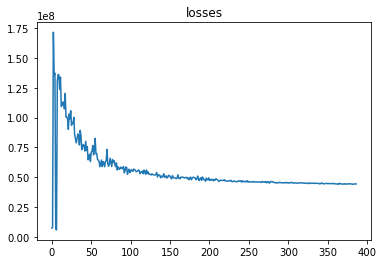

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.351e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.546e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.008e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.265e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.096e

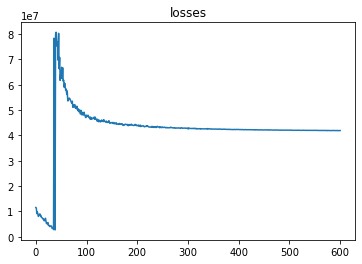

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.351e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.546e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.008e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.265e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.096e

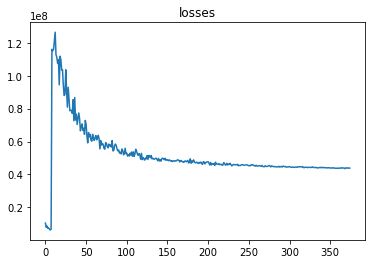

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.351e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.546e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.008e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.265e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.096e

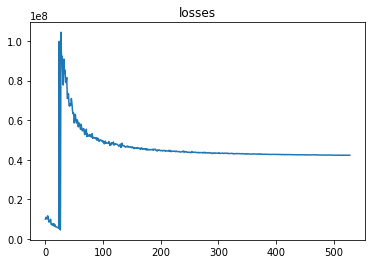

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.351e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.546e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.008e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.265e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.096e

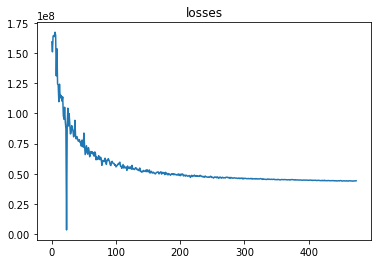

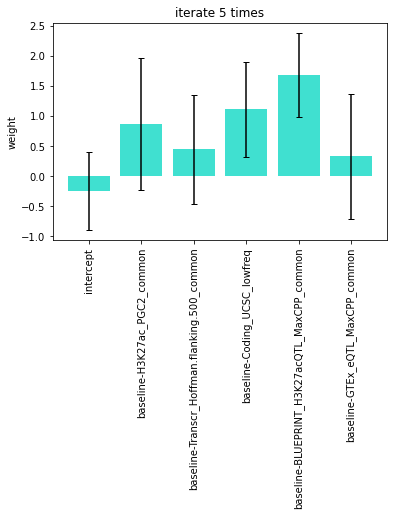

{'mean': tensor([ 0.2305,  1.1654, -0.7781,  0.2548,  1.1033,  0.1983]), 'std': tensor([0.1449, 0.1555, 0.2155, 0.1778, 0.1722, 0.1840]), '5%': tensor([-0.0142,  0.9054, -1.2162, -0.0491,  0.8300, -0.1616]), '95%': tensor([ 0.4246,  1.4213, -0.4374,  0.4949,  1.3616,  0.5009])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


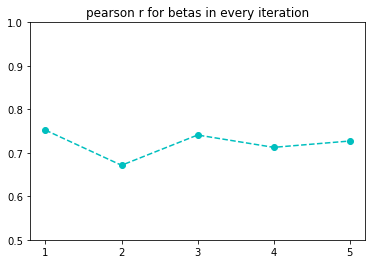

[0.7522324329153465, 0.6713581896573476, 0.7409637754237524, 0.7125899852786646, 0.7271556271245341]


In [8]:
# test on all chr22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22",
    'sst_file' : "test_data/wightman_chr22.tsv",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr',
    'save_fig_path':'0922/bl_5_iter_all_chr22'      
}

test = check_sim_result(param_dict, "all_chr22",refit_time = 5)

## Trying ML anno (bl+ DeepSea + Enformer)

save fig in /gpfs/commons/home/tlin/pic/casioPR/simulation/0922/all_anno_10_iter_1000SNP_ax3_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
There are 4 ld_block. 

... parse annotations ...
Reading annotations from 3 file(s)... 
Successfully loaded 28 annotations for 271699 SNPs
Total of 991 SNPs left after merging with sst
Done in 1.86 seconds 

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 225 iterations. Increasing num_particles to 2.
Done after 106 iterations. Increasing num_particles to 4.
Done after 34 iterations. Increasing num_parti

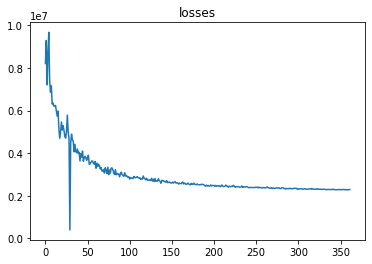

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 258 iterations. Increasing num_particles to 2.
Done after 32 iterations. Increasing num_particles to 4.
Done after 190 iterations. Increasing num_particles to 8.
Done in 30.30 seconds 



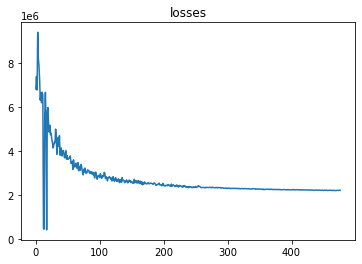

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 218 iterations. Increasing num_particles to 2.
Done after 126 iterations. Increasing num_particles to 4.
Done after 192 iterations. Increasing num_particles to 8.
Done in 34.47 seconds 



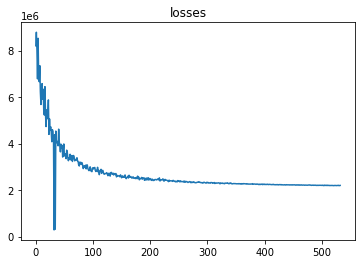

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 212 iterations. Increasing num_particles to 2.
Done after 109 iterations. Increasing num_particles to 4.
Done after 239 iterations. Increasing num_particles to 8.
Done in 38.03 seconds 



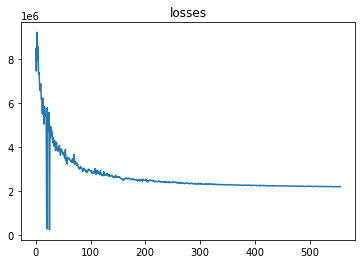

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 230 iterations. Increasing num_particles to 2.
Done after 155 iterations. Increasing num_particles to 4.
Done after 54 iterations. Increasing num_particles to 8.
Done in 21.69 seconds 



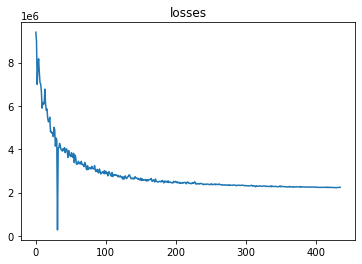

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 213 iterations. Increasing num_particles to 2.
Done after 46 iterations. Increasing num_particles to 4.
Done after 147 iterations. Increasing num_particles to 8.
Done in 25.15 seconds 



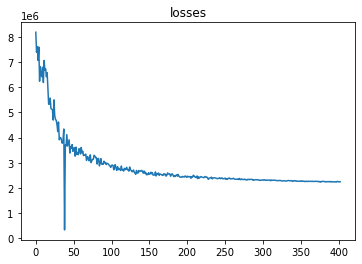

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 279 iterations. Increasing num_particles to 2.
Done after 150 iterations. Increasing num_particles to 4.
Done after 202 iterations. Increasing num_particles to 8.
Done in 38.57 seconds 



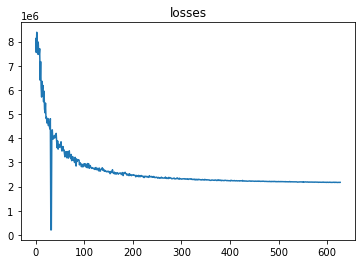

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 301 iterations. Increasing num_particles to 2.
Done after 55 iterations. Increasing num_particles to 4.
Done after 187 iterations. Increasing num_particles to 8.
Done in 32.16 seconds 



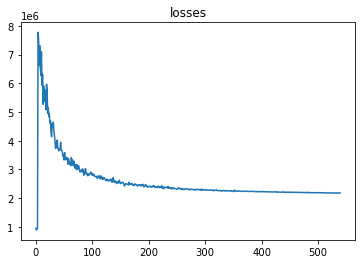

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 263 iterations. Increasing num_particles to 2.
Done after 113 iterations. Increasing num_particles to 4.
Done after 190 iterations. Increasing num_particles to 8.
Done in 34.74 seconds 



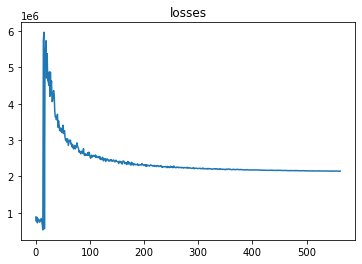

... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 204 iterations. Increasing num_particles to 2.
Done after 58 iterations. Increasing num_particles to 4.
Done after 59 iterations. Increasing num_particles to 8.
Done in 16.35 seconds 



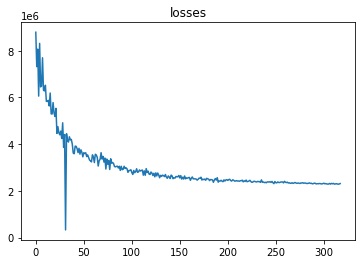

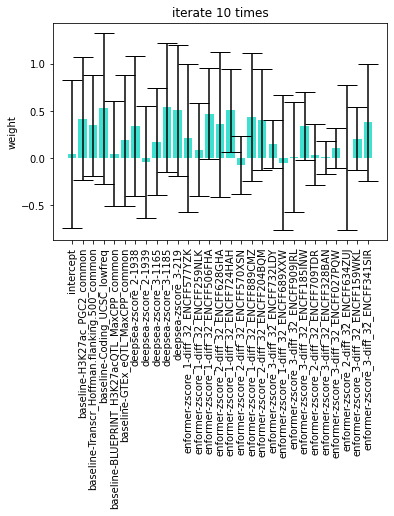

{'mean': tensor([ 0.2343,  0.9342,  0.1906,  0.6516,  0.4040,  0.1063, -0.8138,  0.2719,
         0.3138,  0.0905,  0.5631, -0.1211, -0.0538,  0.5099,  0.2137,  0.6058,
         0.2183,  0.2325,  1.0253,  0.0884, -0.6889,  0.0600,  0.8747,  0.1511,
        -0.0299,  0.5072, -0.2530,  0.1952, -0.0773]), 'std': tensor([0.1883, 0.1896, 0.2853, 0.3575, 0.2885, 0.4339, 0.3348, 0.1892, 0.2179,
        0.2878, 0.1990, 0.3131, 0.2408, 0.5083, 0.3688, 0.2890, 0.2837, 0.5177,
        0.3467, 0.8713, 0.3147, 1.0265, 0.5080, 0.5838, 1.0954, 0.8238, 0.7891,
        0.3417, 0.9865]), '5%': tensor([-0.0647,  0.6265, -0.3596,  0.1068, -0.0575, -0.5796, -1.3619, -0.0870,
        -0.0040, -0.4036,  0.2481, -0.6036, -0.4607, -0.3200, -0.3623,  0.0858,
        -0.2354, -0.5857,  0.2240, -1.4593, -1.2362, -1.5304, -0.0207, -0.9087,
        -1.7899, -0.6788, -1.3976, -0.3727, -1.6698]), '95%': tensor([ 0.5284,  1.2604,  0.5999,  1.1936,  0.9254,  0.7333, -0.2954,  0.6090,
         0.6407,  0.5778,  0.8683, 

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


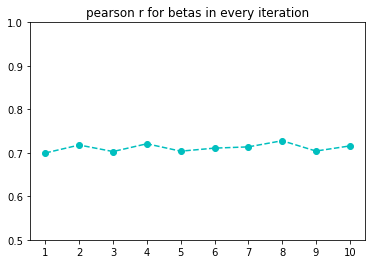

[0.6997114439809355, 0.7179534218393032, 0.702935309269753, 0.7208359607596989, 0.7038053689474298, 0.7107915613154565, 0.7136586903309109, 0.7278236746234383, 0.7040757293818095, 0.7158620678760133]


In [119]:
## sim 1K SNP
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': ','.join([bl_anno,deepsea,enformer]),
    'save_fig_path':'0922/all_anno_10_iter_1000SNP'      
}

test = check_sim_result(param_dict, "check_anno",refit_time = 10)

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 24 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03


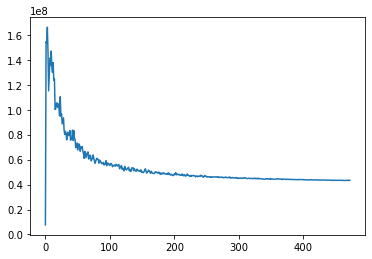

       mean       std        5%       95%
0 -0.455925  0.087000 -0.608210 -0.319303
1  0.717473  0.079256  0.551217  0.833432
2 -1.266708  0.108772 -1.454974 -1.113966
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

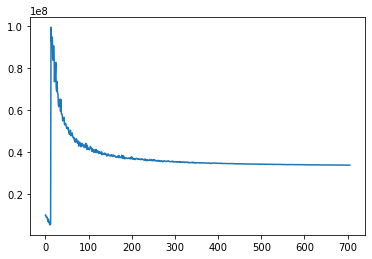

       mean       std        5%       95%
0 -0.650440  0.098642 -0.810978 -0.478541
1 -0.133448  0.083631 -0.275146 -0.003957
2  1.419999  0.071128  1.303378  1.535333
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

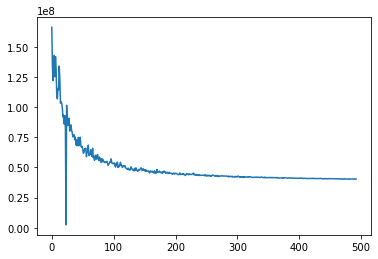

       mean       std        5%       95%
0  1.157213  0.164061  0.885079  1.399936
1  0.190127  0.176418 -0.108608  0.469435
2  0.832910  0.158211  0.584565  1.100665
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

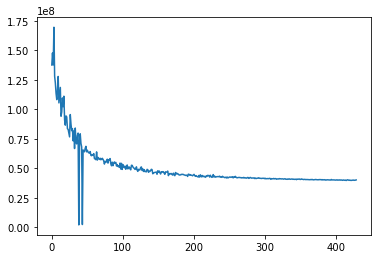

       mean       std        5%       95%
0  0.448358  0.302202 -0.062028  0.985891
1  0.242439  0.341661 -0.474328  0.742734
2  0.911534  0.220689  0.568360  1.257176
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

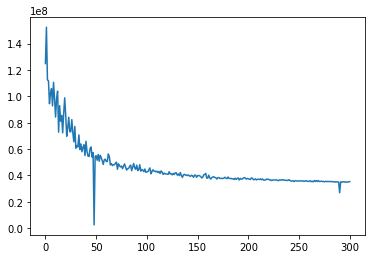

       mean       std        5%       95%
0  0.387550  0.256555 -0.102207  0.817071
1  0.877038  0.267554  0.375995  1.293593
2 -0.518689  0.368568 -1.162243  0.069663
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

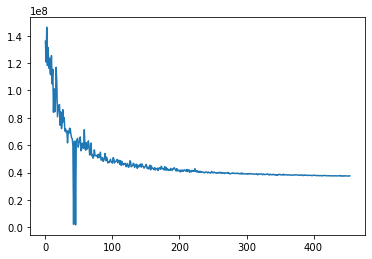

       mean       std        5%       95%
0  0.859656  0.281569  0.427253  1.323339
1  0.759933  0.230610  0.356285  1.152989
2  0.353156  0.312885 -0.167064  0.823504
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

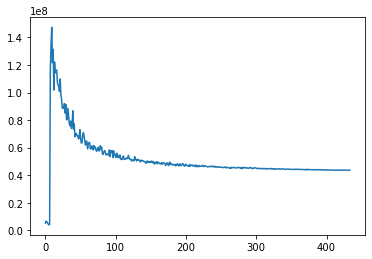

       mean       std        5%       95%
0  0.993982  0.097864  0.819816  1.148935
1  1.343361  0.136027  1.110945  1.533245
2 -0.526433  0.118832 -0.745339 -0.328228
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

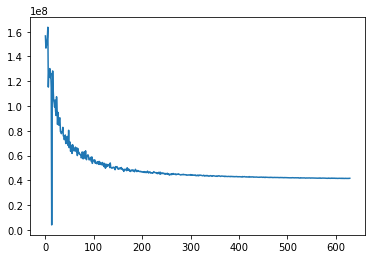

       mean       std        5%       95%
0  0.218754  0.170345 -0.047698  0.495845
1  0.042904  0.116386 -0.150176  0.224723
2 -0.954997  0.116400 -1.111843 -0.752040
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

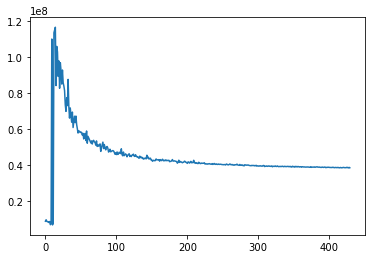

       mean       std        5%       95%
0 -0.944168  0.077141 -1.065274 -0.826210
1 -1.275051  0.130374 -1.492668 -1.067465
2  1.496700  0.107281  1.311948  1.670871
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

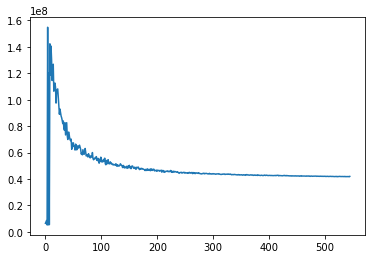

       mean       std        5%       95%
0 -0.203383  0.150384 -0.454674  0.036721
1  2.071481  0.075912  1.930627  2.204082
2 -0.773232  0.126027 -0.944816 -0.567115


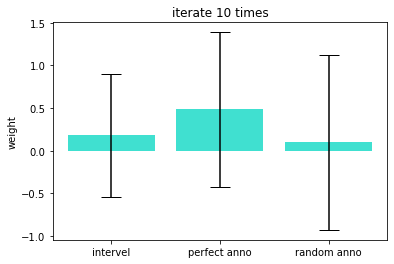

{'mean': tensor([-0.2034,  2.0715, -0.7732]), 'std': tensor([0.1504, 0.0759, 0.1260]), '5%': tensor([-0.4547,  1.9306, -0.9448]), '95%': tensor([ 0.0367,  2.2041, -0.5671])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


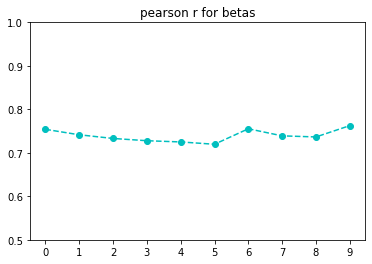

[0.7540347413419254, 0.7414992592807942, 0.7330411011572591, 0.7278447711594472, 0.7250157011890049, 0.7196752155753612, 0.7553155018153669, 0.739028726633243, 0.7365086723094462, 0.7625427005421034]


,0,1,2
0,-0.455925,0.717473,-1.266708
1,-0.650440,-0.133448,1.419999
2,1.157213,0.190127,0.832910
3,0.448358,0.242439,0.911534
4,0.387550,0.877038,-0.518689
5,0.859656,0.759933,0.353156
6,0.993982,1.343361,-0.526433
7,0.218754,0.042904,-0.954997
8,-0.944168,-1.275051,1.496700
9,-0.203383,2.071481,-0.773232


In [135]:
## using all chr22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22", 
    'sst_file' : "test_data/wightman_chr22.tsv", 
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}
anno_test = check_sim_result_loop(param_dict, "all SNPs in CHR22", iteration=10,prop_nz= 0.2)

anno_test[0]

# Try Perfect annotations

fig will be saved in /gpfs/commons/home/tlin/pic/casioPR/simulation/0929/perfect_anno_all_chr22_iter5_cpm_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
There are 24 ld_block. 

prop_nz = 0.200000
simulating anno...
start VI...
Fitting model 1 time(s)
... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fix

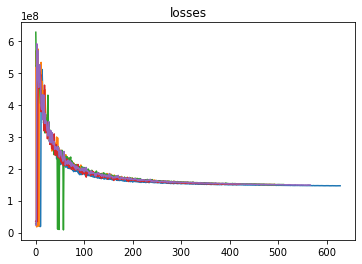

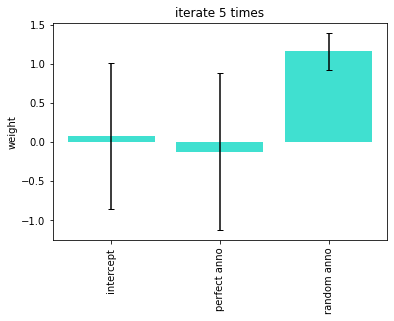

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


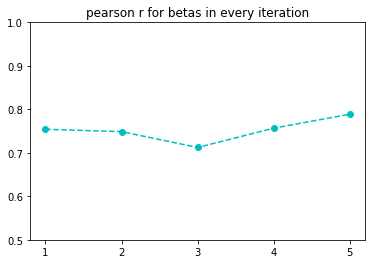

anno_weight
          0         1         2
0  0.517089 -0.864685  0.992142
1  0.924333 -1.325099  1.048595
2  0.524935  0.507272  1.066934
3 -1.450801 -0.113065  1.577626
4 -0.147327  1.153289  1.106203


person R list
[0.7541170127487963, 0.7487030080411662, 0.7123189492917984, 0.7566714741122313, 0.7887698311542628]


In [12]:
## test no anno, whole chr22
#importlib.reload(simulate)
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22",
    'sst_file' : "test_data/wightman_chr22.tsv",
    'n_gwas' : 762971, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000, 
    'anno_path': False,
    'save_fig_name':'perfect_anno_all_chr22'      
}

test = check_sim_result(param_dict, refit_time=5)

fig will be saved in /gpfs/commons/home/tlin/pic/casioPR/simulation/0929/perfect_anno_chr22_prop_nz_0.025_iter5_nhv_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
There are 24 ld_block. 

prop_nz = 0.025000
simulating anno...
start VI...
Fitting model 1 time(s)
... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545

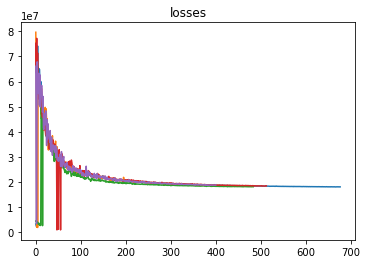

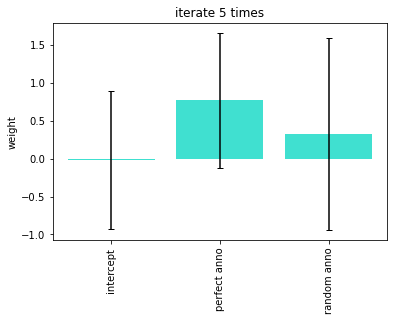

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


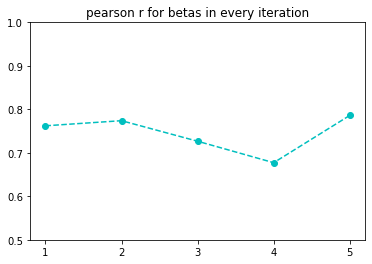

anno_weight
          0         1         2
0  0.554458  1.146267 -0.969303
1  0.827101  0.965424  0.983344
2 -0.619991 -0.567643  1.304726
3  0.436828  0.455732 -1.136857
4 -1.313199  1.826394  1.409378


person R list
[0.7621417737956794, 0.7739011597014909, 0.7266431790210823, 0.6772796007212406, 0.7860378710191174]


(          0         1         2
 0  0.554458  1.146267 -0.969303
 1  0.827101  0.965424  0.983344
 2 -0.619991 -0.567643  1.304726
 3  0.436828  0.455732 -1.136857
 4 -1.313199  1.826394  1.409378,
 [0.7621417737956794,
  0.7739011597014909,
  0.7266431790210823,
  0.6772796007212406,
  0.7860378710191174])

In [13]:
##"chr22, prop_nz=0.025" test

chr22_dict.update(save_fig_name = 'perfect_anno_chr22_prop_nz_0.025')
chr22_dict.update(anno_path=False)
chr22_dict

check_sim_result(chr22_dict, refit_time=5,prop_nz = 0.025)

fig will be saved in /gpfs/commons/home/tlin/pic/casioPR/simulation/0929/perfect_anno_chr22_prop_nz_0.05_iter5_gtk_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
There are 24 ld_block. 

prop_nz = 0.050000
simulating anno...
start VI...
Fitting model 1 time(s)
... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e

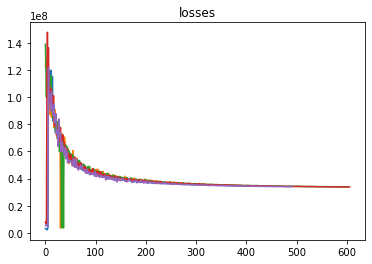

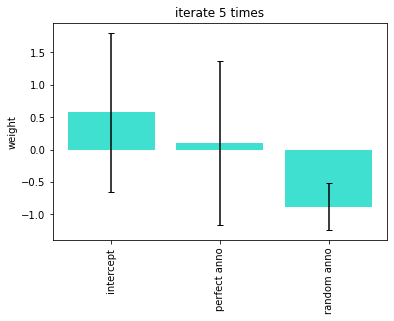

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


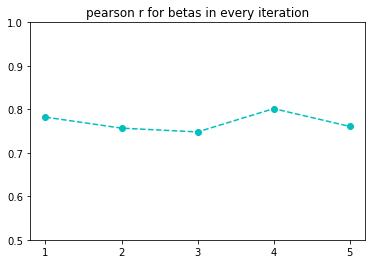

anno_weight
          0         1         2
0  2.384658  0.750097 -0.336792
1  0.114484 -0.670005 -0.920122
2 -0.425127 -0.506776 -1.311889
3 -0.457487  2.002929 -1.069480
4  1.272048 -1.085247 -0.772761


person R list
[0.7821478816538767, 0.7567325855449308, 0.7480682860799754, 0.8016202057480788, 0.7607314715112933]


(          0         1         2
 0  2.384658  0.750097 -0.336792
 1  0.114484 -0.670005 -0.920122
 2 -0.425127 -0.506776 -1.311889
 3 -0.457487  2.002929 -1.069480
 4  1.272048 -1.085247 -0.772761,
 [0.7821478816538767,
  0.7567325855449308,
  0.7480682860799754,
  0.8016202057480788,
  0.7607314715112933])

In [15]:
chr22_dict.update(save_fig_name = 'perfect_anno_chr22_prop_nz_0.05')
chr22_dict.update(anno_path=False)
chr22_dict

check_sim_result(chr22_dict, refit_time=5,prop_nz = 0.05)

fig will be saved in /gpfs/commons/home/tlin/pic/casioPR/simulation/0927/perfect_anno_chr22_prop_nz_0.05_iter20_p2z_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
There are 24 ld_block. 

prop_nz = 0.050000
simulating anno...
start VI...
Fitting model 1 time(s)
... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545

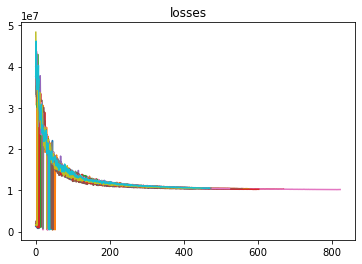

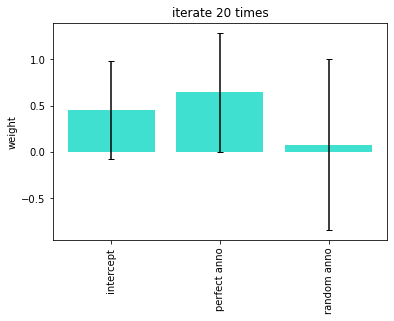

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


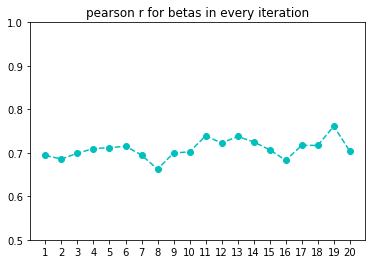

anno_weight
           0         1         2
0   0.373779  1.146277  0.586337
1   0.508229  0.776736  0.783153
2   0.179651  0.793791  1.090876
3   0.799530  1.105222 -0.531646
4   0.457654 -0.429308  0.943773
5  -0.044390  0.232898 -1.185530
6   0.893593  1.077604  0.177772
7   0.335182  0.920174 -1.116768
8   0.673411  0.294885  0.755945
9   0.573663  0.140271 -1.083150
10  1.525467  0.905018  0.530630
11 -0.489733 -0.023552  1.365287
12  0.207184  0.909384  0.895456
13  1.201801 -0.199583 -0.811832
14 -0.015106  0.249565 -1.107042
15  0.042861  0.344934  1.180885
16  1.482029  0.598003 -0.732206
17  0.222520  1.504169 -0.598809
18 -0.212268  2.356910 -0.629446
19  0.426072  0.167134  1.079669


person R list
[0.6939427935977727, 0.6857265666743625, 0.699033617897092, 0.7099246236122394, 0.7117582865962138, 0.7151555299596197, 0.6949350949299262, 0.6624583587307953, 0.6996316113276174, 0.7023041673723568, 0.7390204411161452, 0.7226368021482769, 0.7375926365747234, 0.7251153393741463,

(           0         1         2
 0   0.373779  1.146277  0.586337
 1   0.508229  0.776736  0.783153
 2   0.179651  0.793791  1.090876
 3   0.799530  1.105222 -0.531646
 4   0.457654 -0.429308  0.943773
 5  -0.044390  0.232898 -1.185530
 6   0.893593  1.077604  0.177772
 7   0.335182  0.920174 -1.116768
 8   0.673411  0.294885  0.755945
 9   0.573663  0.140271 -1.083150
 10  1.525467  0.905018  0.530630
 11 -0.489733 -0.023552  1.365287
 12  0.207184  0.909384  0.895456
 13  1.201801 -0.199583 -0.811832
 14 -0.015106  0.249565 -1.107042
 15  0.042861  0.344934  1.180885
 16  1.482029  0.598003 -0.732206
 17  0.222520  1.504169 -0.598809
 18 -0.212268  2.356910 -0.629446
 19  0.426072  0.167134  1.079669,
 [0.6939427935977727,
  0.6857265666743625,
  0.699033617897092,
  0.7099246236122394,
  0.7117582865962138,
  0.7151555299596197,
  0.6949350949299262,
  0.6624583587307953,
  0.6996316113276174,
  0.7023041673723568,
  0.7390204411161452,
  0.7226368021482769,
  0.7375926365747234,


In [11]:
##"chr22, prop_nz=0.025"

chr22_dict.update(save_fig_name = 'perfect_anno_chr22_prop_nz_0.025')
chr22_dict.update(anno_path=False)
chr22_dict

check_sim_result(chr22_dict, refit_time=5,prop_nz = 0.025)

In [ ]:
check_sim_result(chr22_dict, refit_time=20,prop_nz = 0.025)

fig will be saved in /gpfs/commons/home/tlin/pic/casioPR/simulation/0927/perfect_anno_chr22_prop_nz_0.025_iter20_k6i_
... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
There are 24 ld_block. 

prop_nz = 0.025000
simulating anno...
start VI...
Fitting model 1 time(s)
... Starting SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.54

'/gpfs/commons/home/tlin/pic/casioPR/simulation/0929/_betas.pdf'